# Package import



In [71]:
import os
import sys
import h5py
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import backend as K
from keras.models import Sequential

from keras.layers import Input, Dense,Flatten,Dropout
from keras.models import model_from_json

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

from functools import partial
from bayes_opt import BayesianOptimization
from tensorflow.python.keras.optimizer_v2 import rmsprop, adam

import tensorflow as tf

import pickle
import sklearn
import scipy
from scipy.stats import pearsonr

from scipy.ndimage import gaussian_filter1d


tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)

## functions definition

In [3]:
yellow = np.array([251,139 ,36])/255
green = np.array([117, 209, 105])/255
blue = np.array( [5, 148, 255])/255

def plot_variables(data, figsize=10, option='idx', labelsize=16,name = 0):
    """
    """
    plt.clf()
    
    input_dim = len(data[0]['variables'])
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    if type(figsize) == int:
        fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))       
    else:
        fig  = plt.figure(figsize=figsize)   
    # Plot dataset types
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        # Plot only units lines
        for jj in data[0]['ds_name']:
            ax.plot(data[0][jj]['x'], data[0][jj]['y'][:,n], markeredgewidth=0.25, markersize=8)
                          
        # Adjusments
        if (y_min !=None) & (y_max !=None):
            ax.set_ylim(y_min, y_max)
        if x_max !=None:    
            ax.set_xlim(0, x_max)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(data[0]['label'][n], fontsize=labelsize)
        
        # Labels and legend
        if option=='idx':
            plt.xlabel('Time [t]', fontsize=labelsize)
        else:
            plt.xlabel('Time [cycles]', fontsize=labelsize)    
        plt.legend(data[0]['legend'], fontsize=labelsize-2, loc='lower left')
    
    plt.tight_layout()
    plt.show()
    if name != 0:
        plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/'+name+'.pdf',format = 'pdf')

#     plt.close()
    
def plot_predicted_true_rul(log_y_hat_test, unit_sel, Unit_test, C_test, rul_test,name):

    for i in range(len(log_y_hat_test)):
        fig = plt.figure(figsize=(9, 7))
        leg = []
        
        # Plot predicted RUL
        for j in unit_sel:
            y_hat_mean, y_hat_max, y_hat_min = [], [], []
            unit = Unit_test == j  
            c_test = np.sort(C_test[unit])-1
            idx = np.argsort(C_test[unit])
            y_hat_test = log_y_hat_test[i][unit]
            y_hat_test_sorted = y_hat_test[idx]
            for k in np.unique(c_test):
                y_hat_mean.append(np.mean(y_hat_test_sorted[c_test == k]))
                y_hat_max.append(np.max(y_hat_test_sorted[c_test == k]))
                y_hat_min.append(np.min(y_hat_test_sorted[c_test == k]))
            y_hat_mean = np.array(y_hat_mean, dtype=np.float64)
            y_hat_max = np.array(y_hat_max, dtype=np.float64)
            y_hat_min = np.array(y_hat_min, dtype=np.float64)
            plt.plot(np.unique(c_test), y_hat_mean, 'o', alpha=0.7, markersize=5)
            plt.fill_between(np.unique(c_test), y_hat_min, y_hat_max, alpha=0.3)
            leg.append('Unit ' + str(j))
        
        # Plot true RUL
        plt.gca().set_prop_cycle(None)
        for j in unit_sel:        
            unit = Unit_test == j  
            c_test_unique = np.unique(np.sort(C_test[unit])-1)
            rul_test_unique = np.unique(rul_test[unit])
            plt.plot(c_test_unique, rul_test_unique[::-1], alpha=0.7)           
            leg.append('True-Unit ' + str(j))
        plt.legend(leg, loc='upper right')
        plt.ylabel(r'Predicted & True $RUL$ [cycles]')
        plt.xlabel('Time [cycles]')
        plt.ylim(top=90)
    
        plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/'+name+'%i.pdf'%i,format = 'pdf')

def score_cal(y_hat, Y_test):
    d = y_hat - Y_test
    d.ravel()
    score = []
    for i in range(d.shape[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return np.array(score)

    
def print_table(file,model_param):
    f= open("/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/tables/"+file+".tex","w+")
 
    f.write("\createtable[h]\n{Model Architecture}\n{Model Architecture}\n{\label{tab:model}}\n{\\begin{tabular}{lc}\nParameter Name & Value \\\\ \\hline \n")

    f.write(" Number of layers & %i \\\\" %int(np.round(model_param['Hidden layers'])))
    f.write(" Number of nodes & %i \\\\" %int(np.round(model_param['# of nodes'])))

    f.write(" Activation function &  ReLu\\\\" )

    f.write(" Batch size & %i\\\\" %model_param['Batch size'])  
    f.write(" Dropout rate & %.2f\\\\" %model_param['Dropout rate'])
    f.write(" Learning rate& %.2e\\\\" %model_param['Learning rate'])
    
    f.write('\end{tabular}}\n{}')
    f.close() 
    

    
def print_table_loss(model,NASA,RMSE,file):
    f= open("/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/tables/"+file+".tex","w+")
 
    f.write("\createtable[h]\n{Loss}\n{Loss on the test data set}\n{\label{tab:model}}\n{\\begin{tabular}{lcc}\nModel & RMSe & NASA \\\\ \\hline \n")
    for m in range(len(model)):
        f.write("%s & %.3f & %.3e \\\\" %(model[m],RMSE[m],NASA[m]))

    f.write('\end{tabular}}\n{}')
    f.close() 

## Load Training and Test Data

In [258]:
TEST = '/data'
PATH_IN = TEST
SOURCE = 'CMAPSS_Dataset_DS02_Assigment'
SOURCEV = 'CMAPSS_Dataset_DS02_Assigment_X_v'
SOURCED = 'CMAPSS_Dataset_DS02_Assigment_X_s_path1_deno'
#def load_data(PATH_IN, SOURCE)
 
# Time tracking, Operation time (min):  0.004
t = time.clock()

# Variable name
varname = ['alt', 'Mach', 'TRA', 'T2',
          'T24', 'T30', 'T40', 'T48', 'T50', 
          'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50',
          'Nf', 'Nc', 'Wf',
          'HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCE + '.h5', 'r') as hdf:
# Nominal Training set
    W_train = np.array(hdf.get('W_train'))                 # W
    X_s_train = np.array(hdf.get('X_s_train'))             # X_s
    T_train = np.array(hdf.get('T_train'))                 # T
    Y_train = np.array(hdf.get('Y_train'))                 # RUL  
    U_train = np.array(hdf.get('U_train'))                 # Units
    C_train = np.array(hdf.get('C_train'))                 # Cycles

# Nominal Test set - Past
    W_test = np.array(hdf.get('W_test'))                   # W
    X_s_test = np.array(hdf.get('X_s_test'))               # X_s
    T_test = np.array(hdf.get('T_test'))                   # T
    Y_test = np.array(hdf.get('Y_test'))                   # RUL  
    U_test = np.array(hdf.get('U_test'))                   # Units
    C_test = np.array(hdf.get('C_test'))                   # Cycles

# Nominal Test set - Future
    W_path1 = np.array(hdf.get('W_path1'))                 # W
    X_s_path1 = np.array(hdf.get('X_s_path1'))             # X_s
    T_path1 = np.array(hdf.get('T_path1'))                 # T
    Y_path1 = np.array(hdf.get('Y_path1'))                 # RUL  
    U_path1 = np.array(hdf.get('U_path1'))                 # Units
    C_path1 = np.array(hdf.get('C_path1'))                 # Cycles

# Alternative paths
    T_path2 = np.array(hdf.get('T_path2'))                 # T
    T_path3 = np.array(hdf.get('T_path3'))                 # T

# Noisy Test set
    X_s_test_db60 = np.array(hdf.get('X_s_test_db60'))     # X_s

# De-Noised Training set
    X_s_train_deno = np.array(hdf.get('X_s_train_deno'))   # X_s

# De-Noised Test set
    X_s_test_deno = np.array(hdf.get('X_s_test_deno'))     # X_s 

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCEV + '.h5', 'r') as hdf:
    X_v_train = np.array(hdf.get('X_v_train'))             # X_v train
    
    X_v_test = np.array(hdf.get('X_v_test'))               # X_v test 

    X_v_path1 = np.array(hdf.get('X_v_path1'))             # X_s path1

with h5py.File(os.getcwd()+PATH_IN + "/" + SOURCED + '.h5', 'r') as hdf:
    X_s_path1_deno = np.array(hdf.get('X_s_path1_deno'))   # X_s path1

print('')
print("Operation time (min): " , (time.clock()-t)/60)
print('')
    


Operation time (min):  0.007819750000029066



/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [6]:
print ("Units train set: ", np.unique(U_train))
print ("Units test set: ", np.unique(U_test))
print('')
print ("W_train shape: ", W_train.shape)
print ("W_test shape: ", W_test.shape)
print('')
print ("X_s_train shape: ", X_s_train.shape)
print ("X_s_test shape: ", X_s_test.shape)
print ("X_s_test_db60: ", X_s_test_db60.shape)

print('')
print ("X_v_train shape: ", X_v_train.shape)
print ("X_v_test shape: ", X_v_test.shape)
print('')
print ("T_train shape: ", T_train.shape)
print ("T_test shape: ", T_test.shape)

Units train set:  [ 2  5 10 16 18 20]
Units test set:  [11 14 15]

W_train shape:  (526347, 4)
W_test shape:  (83135, 4)

X_s_train shape:  (526347, 16)
X_s_test shape:  (83135, 16)
X_s_test_db60:  (83135, 16)

X_v_train shape:  (526347, 11)
X_v_test shape:  (83135, 11)

T_train shape:  (526347, 3)
T_test shape:  (83135, 3)


## Part 0: Data Exploration


['HPT_eff_mod', 'LPT_eff_mod', 'LPT_flow_mod']


<Figure size 432x288 with 0 Axes>

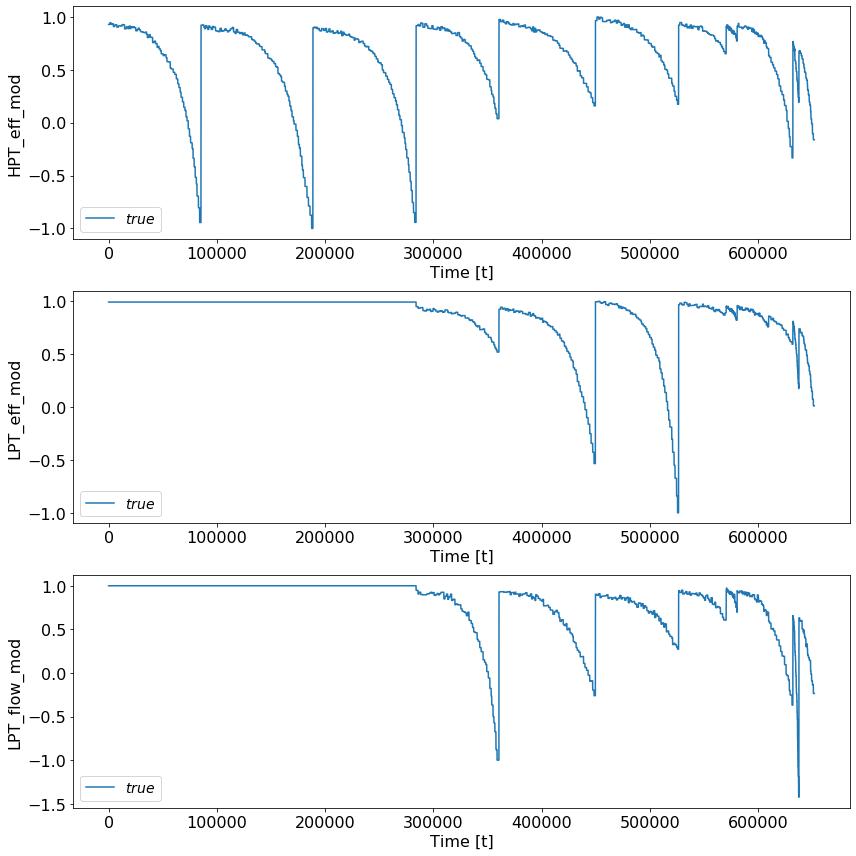

In [7]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[-3:]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$true$']
data[0]['ds_name'] = ['true']
data[0]['option'] = 'Save'

# Data to plot
data[0]['true'], data[0]['pred'] = {}, {}
data[0]['true']['y'] = np.concatenate((T_train, T_test, T_path1))
data[0]['true']['x'] = np.arange(data[0]['true']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')

### Training set exploration

<IPython.core.display.Javascript object>


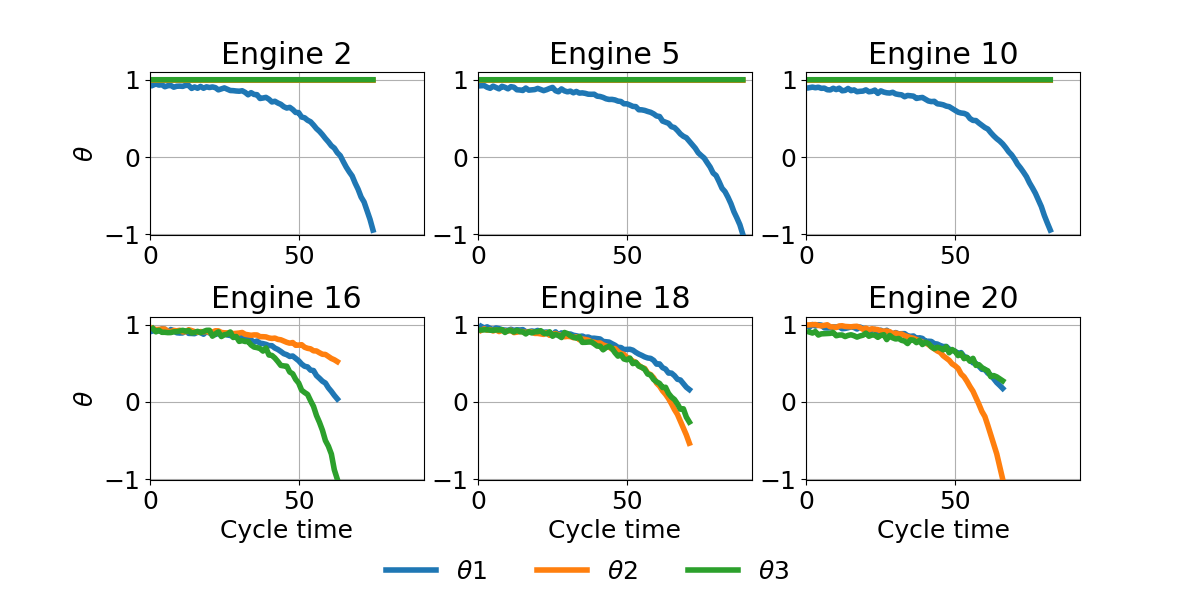

75
89
82
63
71
66


In [58]:
plt.rcParams.update({'font.size': 18})
%matplotlib notebook
fig,axes = plt.subplots(nrows = 3, ncols = 1,figsize=(12,6))


i = 1

for u in [2,5,10,16,18,20]:
    ax = plt.subplot(2,3,i)
    ax.plot(C_train[U_train == u],T_train[(U_train == u).ravel(),:], linewidth=4)
    
#     plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"])

    if (i-1)%3 == 0:
        ax.set(ylabel = "$\\theta$")
    if i > 3 :
        ax.set(xlabel='Cycle time')
    ax.set(title = 'Engine %i' %u)
    plt.grid(which =  'both')
    plt.xlim(0,92)
    plt.ylim(-1.01,1.1)

    i += 1
fig.subplots_adjust(bottom=0.2)       
fig.subplots_adjust(hspace = 0.5) 
plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"],loc='lower center', bbox_to_anchor= (-.8, -.7), ncol=3,
            borderaxespad=0, frameon=False)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot1_overview.pdf',format = 'pdf')
 
    


### Test set exploration

<IPython.core.display.Javascript object>


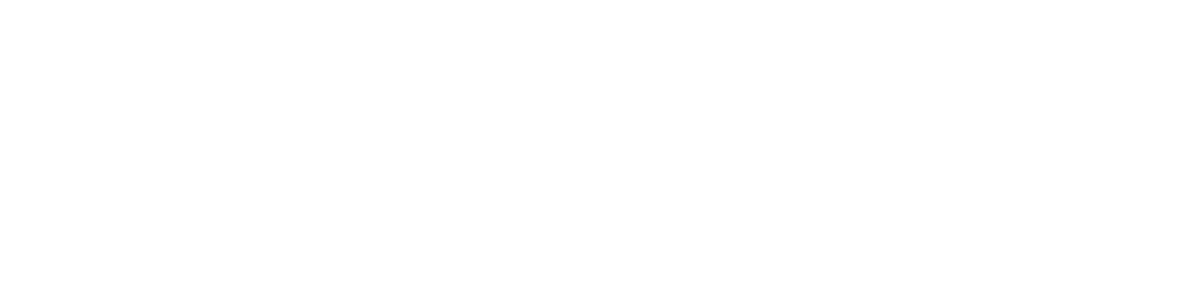

40
50
45


In [9]:

plt.rcParams.update({'font.size': 18})
%matplotlib notebook
fig,axes = plt.subplots(nrows = 1, ncols = 4,figsize=(12,3))


i = 1

for u in [11,14,15]:
    ax = plt.subplot(1,4,i)
    ax.plot(C_test[U_test == u],T_test[(U_test == u).ravel(),:], linewidth=4)
    
#     plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"])

    if (i-1)%3 == 0:
        ax.set(ylabel = "$\\theta$")
    ax.set(xlabel='Cycle time')
    ax.set(title = 'Engine %i' %u)
    plt.grid(which =  'both')
    plt.xlim(0,50)
    plt.ylim(0.6,1)

    i += 1
    print(max(C_test[U_test == u]))
ax = plt.subplot(1,4,i)
ax.plot(C_train[U_train == 18],T_train[(U_train == 18).ravel(),:], linewidth=4)

ax.set(xlabel='Cycle time')
ax.set(title = 'Engine 18' )
plt.grid(which =  'both')
plt.xlim(0,50)
plt.ylim(0.6,1)
fig.subplots_adjust(bottom=0.3)       
fig.subplots_adjust(wspace = 0.3) 
plt.legend(["$\\theta 1$","$\\theta 2$","$\\theta 3$"],loc='lower center', bbox_to_anchor= (-1.2, -.55), ncol=3,
            borderaxespad=0, frameon=False)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot2_overview_test.pdf',format = 'pdf')
 
    


### Test and training set look alike

<IPython.core.display.Javascript object>


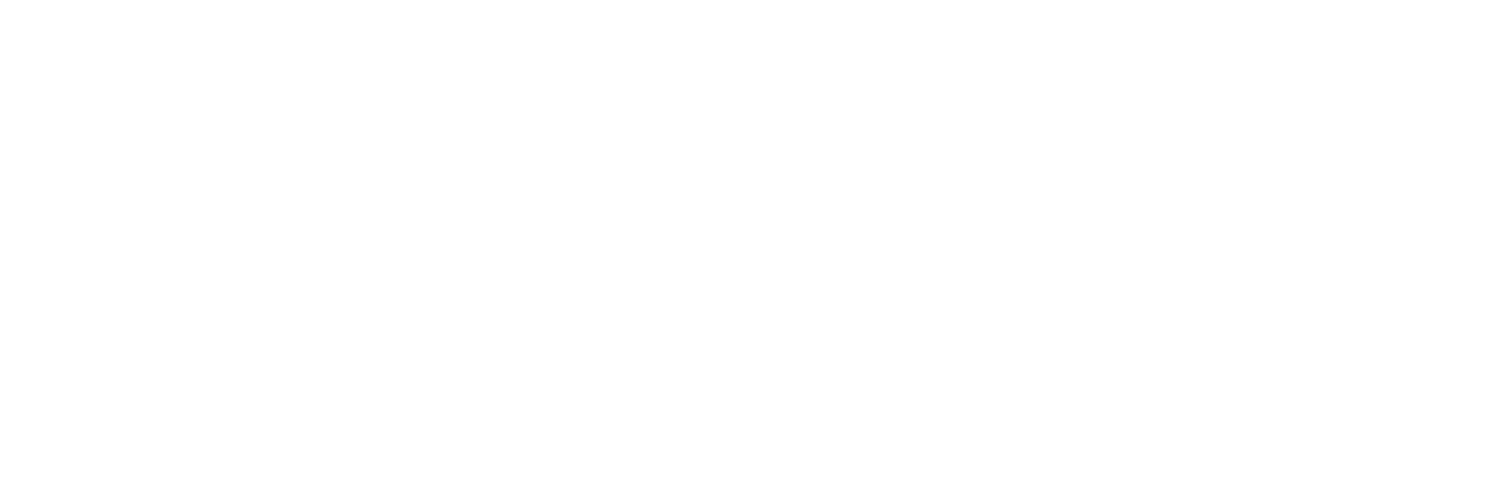

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [10]:
%matplotlib notebook

fig = plt.figure(4,figsize=(15, 5))
grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
pca_ax = fig.add_subplot(grid[:4, 7:])

pca1 = PCA()
pca2 = PCA()
pca3 = PCA()

pca1.fit(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))
pca_ax.plot(range(1,pca1.explained_variance_ratio_.shape[0]+1),pca1.explained_variance_ratio_,label = 'both',c = blue)

pca2.fit(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1))
pca_ax.plot(range(1,pca2.explained_variance_ratio_.shape[0]+1),pca2.explained_variance_ratio_,label = 'Train',c = yellow)

pca3.fit(np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1))
pca_ax.plot(range(1,pca3.explained_variance_ratio_.shape[0]+1),pca3.explained_variance_ratio_,label = 'Test',c = green)


plt.xticks([2,4,6,8,10])


# plt.yticks([0,pca.explained_variance_ratio_[2],0.2,0.4,0.6],[0,round(pca.explained_variance_ratio_[2],2),0.2,0.4,0.6])
# plt.xticks([3,10,20,30])



plt.grid(which =  'both')
pca_ax.set(xlabel = 'th pricipal component',ylabel = 'Explanation', title= '(a) Principal component analysis')

plt.xlim(0,10)
plt.legend(['Both','Train','Test'],loc='lower center', bbox_to_anchor= (-.4, -2.25), ncol=3,
            borderaxespad=0, frameon=False)
vec_ax = fig.add_subplot(grid[7:, 7:])

pca1 = PCA(n_components = 2)
pca2 = PCA(n_components = 2)
pca3 = PCA(n_components = 2)
# vec_ax.plot([0,pca1.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'both')
# vec_ax.plot([0,pca2.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'Train',c = yellow)
# vec_ax.plot([0,pca3.singular_values_[0]],[0,pca3.singular_values_[1]],label = 'Test',c = green)
vec_ax.set(title = '(b)2 first PC vector')
# vec_ax.text(0, 0.6, '           1st PC    2nd PC')

# vec_ax.text(0, 0.4, 'Both  : %.2f  %.2f' %(pca1.singular_values_[0],pca1.singular_values_[1]))
# vec_ax.text(0, 0.2, 'Train : %.2f  %.2f' %(pca2.singular_values_[0],pca2.singular_values_[1]))
# vec_ax.text(0, 0, 'Test  : %.2f    %.2f' %(pca3.singular_values_[0],pca3.singular_values_[1]))

vec_ax.plot(-1,0,c= 'black',label = 'PC1')
vec_ax.plot(-1,0,c= 'black',marker = '*',label = 'PC2')

plt.legend(loc='lower center', bbox_to_anchor= (1.2, 0),ncol=1,
            borderaxespad=0, frameon=False)

pca1.fit(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))
vec_ax.plot(range(pca1.components_.shape[1]),pca1.components_[0,:],label = 'Both', c = blue,marker = '*')
vec_ax.plot(range(pca1.components_.shape[1]),pca1.components_[1,:],label = 'Both', c = blue)

pca2.fit(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1))
vec_ax.plot(range(pca2.components_.shape[1]),pca2.components_[0,:],label = 'Train',c = yellow,marker = '*')
vec_ax.plot(range(pca2.components_.shape[1]),pca2.components_[1,:],label = 'Train',c = yellow)

pca3.fit(np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1))

vec_ax.plot(range(pca3.components_.shape[1]),pca3.components_[0,:],label = 'Test',c = green,marker = '*')
vec_ax.plot(range(pca3.components_.shape[1]),pca3.components_[1,:],label = 'Test',c = green)
vec_ax.set(xlabel = 'Component',ylabel = 'Values')

plt.xlim(0,34)

pca = PCA(n_components = 2)

principalComponents = pca.fit_transform(np.append(np.concatenate([W_train,X_s_train,X_v_train,T_train],axis = 1)
                  ,np.concatenate([W_test,X_s_test,X_v_test,T_test],axis = 1)
                  ,axis=0))





main_ax = fig.add_subplot(grid[:, :6])

main_ax.scatter(principalComponents[:W_train.shape[0],0]
            ,principalComponents[:W_train.shape[0],1],c = yellow,marker = '*',label = 'Train')
#             ,principalComponents[:W_train.shape[0],2]

main_ax.scatter(principalComponents[-W_test.shape[0]:,0]
            ,principalComponents[-W_test.shape[0]:,1],c = green,marker = '*',label = 'Test')
#             ,principalComponents[-W_test.shape[0]:,2]
main_ax.set(xlabel='1st Principal component', ylabel='2nd Principal component',title = ' (c) Scatter plot')


fig.subplots_adjust(bottom=0.2)       

plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot3_PCA.pdf',format = 'pdf')


In [11]:
np.mean(Y_train,axis = 0)


array([37.32748928])

## Part 1 - Pure Data-Driven Prognostics Model with Supervised Learning (SL) 
### Bayesian opti
Function definition + split training in validation and train

In [259]:
TestX = np.concatenate((W_test, X_s_test),axis = 1)

AllX = np.concatenate([W_train, X_s_train],axis = 1)

X_train, X_val, y_train, y_val  =  train_test_split(AllX, Y_train, test_size=0.2, random_state=1)


In [13]:
def nasa_cost(y_true,y_pred):
    delta = y_true-y_pred

    delta[delta>0] = delta[delta>0]/13
    delta[delta<0] = -delta[delta<0]/10

    delta = np.exp(delta)
    return sum(delta)
def RMSE(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 
def nasa_cost_tens(y_hat, Y_test):
    d = y_hat - Y_test
    score = []
    print(tf.size(d,out_type=np.int32))
    for i in range(tf.shape(d,out_type=np.int32)[0]):
        if d[i] >= 0:
            score.append(np.exp(d[i]/10) - 1)
        else:
            score.append(np.exp(-d[i]/13) - 1)
    return tf.keras.backend.sum(score)


In [14]:
def create_model(HL,NumN,act,dropout_rate,shape = 20):
    NumN = int(np.round(NumN))
    HL = int(np.round(HL))
    
    if np.sign(act) == -1:
        act = 'relu'
    else:
        act = 'tanh'
    model = Sequential()
    model.add(Dense(NumN,activation = act,input_shape = (shape,)))
    for i in range(HL-1):
        model.add(Dense(NumN,activation = act))
        model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation=act))
    return model
    del(model)

In [15]:
def fit_with(HL,NumN,act,batch_size, dropout_rate, lr):
    
    batch_size = int(2**(np.round(batch_size)))
    
    # Create the model using a specified hyperparameters.
    model = create_model(HL,NumN,act,dropout_rate)

    # Train the model for a specified number of epochs.
    optimizer = rmsprop.RMSProp(learning_rate=lr)
    model.compile(loss=RMSE,
                  optimizer=optimizer)
    #,metric=score_cal)

    # Train the model with the train dataset.
    model.fit(x=X_train,y = y_train, epochs=5,
              batch_size=batch_size, verbose=0)
    # Evaluate the model with the eval dataset.
    y_pred = model.predict(X_val, verbose=0)
    print('Test nasa:', nasa_cost(y_val,y_pred))
    print('Test RMSE:', np.sqrt(np.mean((y_pred-y_val)**2)))

    # Return the accuracy.
    
    return -np.sqrt(np.mean((y_pred-y_val)**2))
    del(y_pred,batch_size,model)

verbose = 1
fit_with_partial = partial(fit_with)


### optimization

In [17]:

# Bounded region of parameter space
# pbounds = {'HL':(5,5)
#            ,'NumN':(20,200)
#            ,'act' :(-1,1)
#            ,'batch_size' :(8,8)
#            ,'dropout_rate': (0, 0.5)
#            ,'lr': (1e-4, 1e-2)}

# optimizer = BayesianOptimization(
#     f=fit_with_partial,
#     pbounds=pbounds,
#     verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
#     random_state=1,
# )

# optimizer.maximize(init_points=100, n_iter=50)


# # for i, res in enumerate(optimizer.res):
# #     print("Iteration {}: \n\t{}".format(i, res))

# print(optimizer.max)
# with open('model_param4.pickle', 'wb') as f:
# #     pickle.dump(optimizer.max,f)
# corr = pearsonr(opti_pd['Target'], opti_pd['Hidden layers'])

#     corr = np.append(corr,pearsonr(opti_pd['Target'], opti_pd[i]))
    


### Load data from past opti and print table and pic

<IPython.core.display.Javascript object>


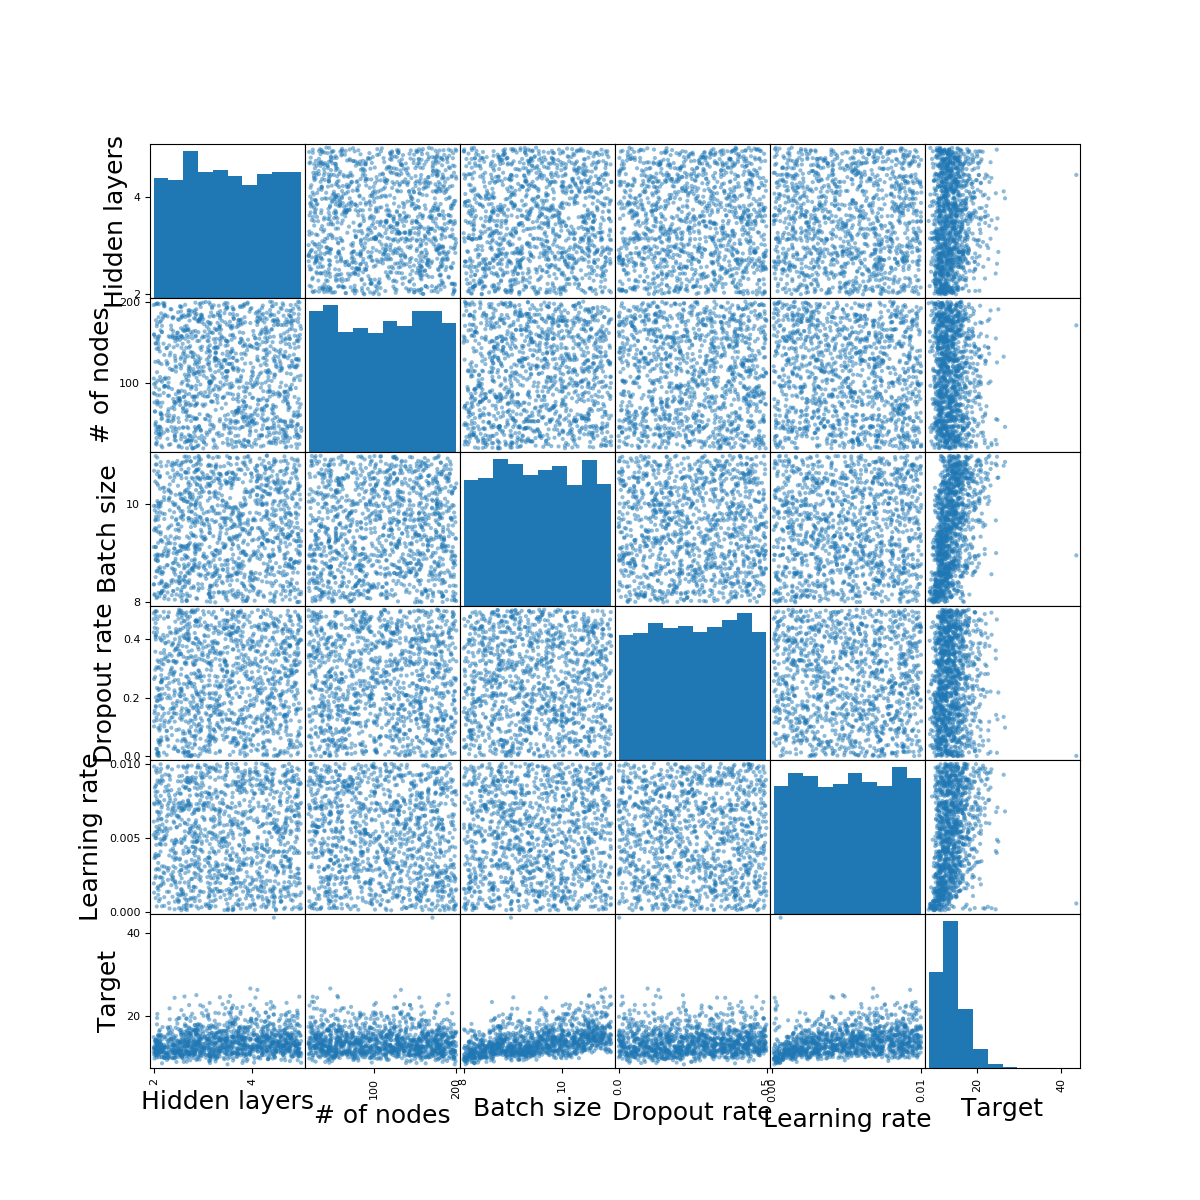

/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  from ipykernel import kernelapp as app


In [55]:
opti_pd = pd.read_pickle('opti_pd.pickle')

opti_pd['Target'] = -opti_pd['Target']
opti_pd.rename(columns={'dropout_rate':'Dropout rate',
                       'HL' : 'Hidden layers',
                       'NumN' : '# of nodes',
                       'batch_size' : 'Batch size',
                       'lr':'Learning rate'}, inplace=True)



fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

pd.plotting.scatter_matrix(opti_pd,ax = ax)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/A2_Correlation.pdf',format = 'pdf')


f= open("/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/tables/corr_table.tex","w+")
f.write("\createtable[h]\n{Correlation}\n{Correlation on the Loss and parameters}\n{\label{tab:corr}}")

f.write(opti_pd.corr().to_latex())

f.write('\end{tabular}}\n{}')
f.close() 

opti_pd['# of nodes'] = np.round(opti_pd['# of nodes'])
opti_pd['Hidden layers'] = np.round(opti_pd['Hidden layers'])
opti_pd['Batch size'] = 2**(np.round(opti_pd['Batch size']))

f= open("/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/tables/Corr.tex","w+")

f.write("\createtable[h]\n{Correlation}\n{Parameters influence on performance}\n{\label{tab:Corr}}\n{\\begin{tabular}{lcc}\nParameter & Correlation & P-value \\\\ \\hline \n")
for i in opti_pd.columns[:5]:
        f.write("%s & %.3f & %.3e \\\\\n" %(i,pearsonr(opti_pd['Target'], opti_pd[i])[0],pearsonr(opti_pd['Target'], opti_pd[i])[1]))

f.write('\end{tabular}}\n{}')
f.close() 

## Creation and train of final model

In [260]:
opti_pd = opti_pd.sort_values(['Target'])

model_param = opti_pd.loc[0]

model_rul = create_model(model_param['Hidden layers'],model_param['# of nodes'],-1,model_param['Dropout rate'],AllX.shape[1])

# model = create_model(2,5,-1,0.2)

optimizer_m = adam.Adam(learning_rate= model_param['Learning rate'])#
model_rul.compile(loss=RMSE,
                  optimizer=optimizer_m)


# hist = model.fit(x=AllX,y = Y_train, epochs=10,
#               batch_size=int(2**(np.round(model_param['batch_size']))), verbose=1,validation_data=(X_val,y_val))

hist = model_rul.fit(x=AllX,y = Y_train, epochs=10,
              batch_size=int(model_param['Batch size']), verbose=1,validation_data=(X_val,y_val))

Train on 526347 samples, validate on 105270 samples
Epoch 1/10
526347/526347 [==============================] - 57s 108us/step - loss: 11.5688 - val_loss: 8.9856
Epoch 2/10
526347/526347 [==============================] - 56s 106us/step - loss: 9.0747 - val_loss: 9.2751
Epoch 3/10
526347/526347 [==============================] - 55s 105us/step - loss: 8.8869 - val_loss: 8.2064
Epoch 4/10
526347/526347 [==============================] - 54s 103us/step - loss: 8.6688 - val_loss: 9.7751
Epoch 5/10
526347/526347 [==============================] - 55s 105us/step - loss: 8.5703 - val_loss: 8.8155
Epoch 6/10
526347/526347 [==============================] - 55s 105us/step - loss: 8.4614 - val_loss: 8.9974
Epoch 7/10
526347/526347 [==============================] - 56s 105us/step - loss: 8.3201 - val_loss: 9.8339
Epoch 8/10
526347/526347 [==============================] - 54s 103us/step - loss: 8.2043 - val_loss: 8.6357
Epoch 9/10
526347/526347 [==============================] - 56s 107us/step 

In [189]:
model_rul.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 150)               3150      
_________________________________________________________________
dense_6 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 151       
Total params: 48,601
Trainable params: 48,601
Non-trainable params: 0
__________________________________________________

<IPython.core.display.Javascript object>


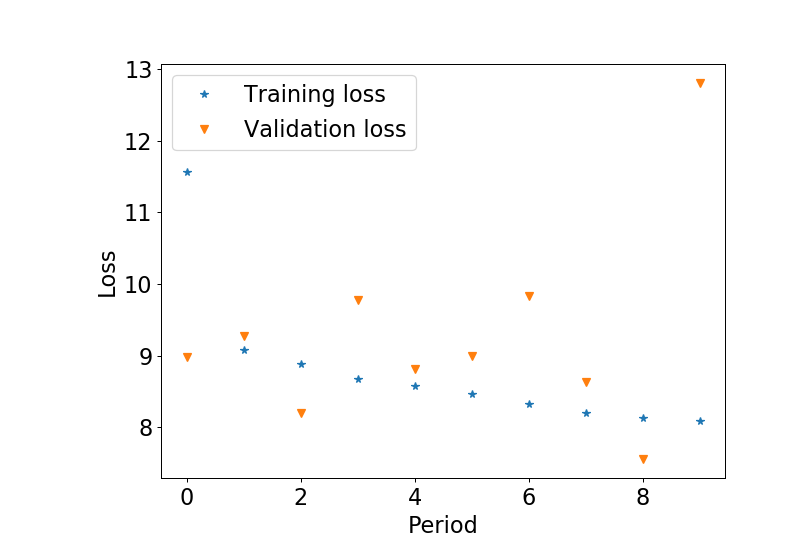

In [263]:
print_table('tableModel',model_param)

%matplotlib notebook

fig = plt.figure(6,figsize = (9,6))
ax = fig.gca()

ax.plot(hist.history['loss'],'*',label = 'Training loss')
ax.plot(hist.history['val_loss'],'v',label = 'Validation loss')
ax.set(xlabel = 'Period',ylabel='Loss')
plt.legend()
# ax.set_yscale('log')
fig.subplots_adjust(left=0.2)
plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/plot5_loss.pdf',format = 'pdf')


## Noise data set

In [265]:
Y_hat_test = model_rul.predict(x=TestX)


Y_hat_test_noise = model_rul.predict(x=np.concatenate((W_test, X_s_test_db60),axis = 1))


scores = score_cal(Y_hat_test, Y_test)
scores_noise = score_cal(Y_hat_test_noise, Y_test)

print('')
print(r's:', np.sum(scores),np.sum(scores_noise))
print('RMSE:', np.sqrt(np.mean((Y_hat_test - Y_test)**2)),np.sqrt(np.mean((Y_hat_test_noise - Y_test)**2)))
# print_table_loss(['Model 1 :','Model 1 with noise :'],[np.sum(scores),np.sum(scores_noise)
#                     ],[np.sqrt(np.mean((Y_hat_test - Y_test)**2)),np.sqrt(np.mean((Y_hat_test_noise - Y_test)**2))],'Loss_table')


s: 84068.74432726584 127941.87111146699
RMSE: 9.049223555530036 10.411419727270914


## Noise data set mitigation
### gaussian_filter1d

In [266]:
all_pd = pd.DataFrame(np.concatenate((C_test,U_test,Y_test,W_test, X_s_test_db60),axis = 1))
all_pd = all_pd.sort_values([0,1])
Y_test_noise = np.array(all_pd.iloc[:,2:3])
W_test_noise = np.array(all_pd.iloc[:,3:4])

for sigma in [1,5,10,30,50,100,200,500,1000,2000,5000,10000]:
    X_s_test_db60_2 = gaussian_filter1d(all_pd.iloc[:,4:],sigma = sigma,axis = 0)


    Y_hat_test_noise_2 = model_rul.predict(x=np.concatenate((W_test_noise, X_s_test_db60_2),axis = 1))

    scores_noise_2 = score_cal(Y_hat_test_noise_2, Y_test_noise)
    print(sigma)
    print(r's:',np.sum(scores_noise_2))
    print('RMSE:', np.sqrt(np.mean((Y_hat_test_noise_2 - Y_test_noise)**2)))
    
    
print('')

# print_table_loss(['Model 1 :','Model 1 with noise :'],[np.sum(scores),np.sum(scores_noise)
#                     ],[np.sqrt(np.mean((Y_hat_test - Y_test)**2)),np.sqrt(np.mean((Y_hat_test_noise - Y_test)**2))],'Loss_table')

1
s: 95480.3668958379
RMSE: 8.904579278640053
5
s: 84367.99899580804
RMSE: 8.405575573099728
10
s: 86393.9863120657
RMSE: 8.67616953690185
30
s: 129547.88863692885
RMSE: 11.013795205863731
50
s: 234946.43332599322
RMSE: 14.369527623912525
100
s: 497786.0248091281
RMSE: 20.07571393001956
200
s: 819169.0705750168
RMSE: 25.190890019626774
500
s: 1115403.2677814818
RMSE: 28.69098002425808


KeyboardInterrupt: 

## Noise data set mitigation
### moving average

In [268]:

window = 5

for window in [1,2,3,4,5,10]:
    X_i = all_pd.rolling(window=window).mean()
    X_i.iloc[:window,:] = all_pd.iloc[:window,:]
    Y_hat_test_noise_3 = model_rul.predict(x=np.concatenate((W_test_noise, X_i.iloc[:,4:]),axis = 1))

    scores_noise_3 = score_cal(Y_hat_test_noise_3, Y_test_noise)
    print(window)
    print(r's:',np.sum(scores_noise_3))
    print('RMSE:', np.sqrt(np.mean((Y_hat_test_noise_3 - Y_test_noise)**2)))
    
    
# print('')



1
s: 127941.8705597154
RMSE: 10.411419703770179
2
s: 109331.96438518158
RMSE: 9.58480540020318
3
s: 105585.73905557385
RMSE: 9.403357840681437
4
s: 106150.13014150003
RMSE: 9.433318154145264
5
s: 108728.40370560327
RMSE: 9.561799604640319
10
s: 134141.04369057316
RMSE: 10.67981557722343


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54051,50.0,14.0,26.0,-0.950210,-0.026190,-0.767133,0.860188,0.358227,0.315713,0.502962,...,0.469370,0.316394,0.250638,0.133903,0.136012,0.134381,0.311716,0.303847,0.333006,0.104374
54052,50.0,14.0,26.0,-0.954931,-0.034521,-0.798775,0.860778,0.358212,0.315734,0.502989,...,0.469217,0.316283,0.250557,0.133869,0.135978,0.134347,0.311573,0.303939,0.333027,0.104363
54053,50.0,14.0,26.0,-0.959466,-0.042969,-0.829282,0.861126,0.358196,0.315755,0.503017,...,0.469065,0.316172,0.250477,0.133836,0.135944,0.134313,0.311431,0.304031,0.333049,0.104352
54054,50.0,14.0,26.0,-0.963814,-0.051635,-0.856278,0.861180,0.358181,0.315776,0.503044,...,0.468912,0.316061,0.250396,0.133803,0.135910,0.134279,0.311289,0.304123,0.333070,0.104340


In [ ]:
all_pd = all_pd.sort_values(by = [0,1])

Y_hat_test_noise_2 = model_rul.predict(x=all_pd.iloc[:,3:])
Y_hat_test_noise = model_rul.predict(x=np.concatenate((W_test, X_s_test_db60),axis = 1))


# scores_noise_2 = score_cal(Y_hat_test_noise_2, Y_test_noise)
# print(sigma)
# print(r's:',np.sum(scores_noise_2))
# print('RMSE:', np.sqrt(np.mean((Y_hat_test_noise_2 - Y_test_noise)**2)))

# scores_noise= score_cal(Y_hat_test_noise, Y_test)
# print(sigma)
# print(r's:',np.sum(scores_noise))
# print('RMSE:', np.sqrt(np.mean((Y_hat_test_noise - Y_test)**2)))

all_pd.iloc[:,3:].shape
np.concatenate((W_test, X_s_test_db60),axis = 1).shape

np.sum(all_pd.iloc[:,3:] != np.concatenate((W_test, X_s_test_db60),axis = 1))

np.sum(Y_hat_test_noise_2 != Y_hat_test_noise )

## Noise data set mitigation
### fft

<IPython.core.display.Javascript object>


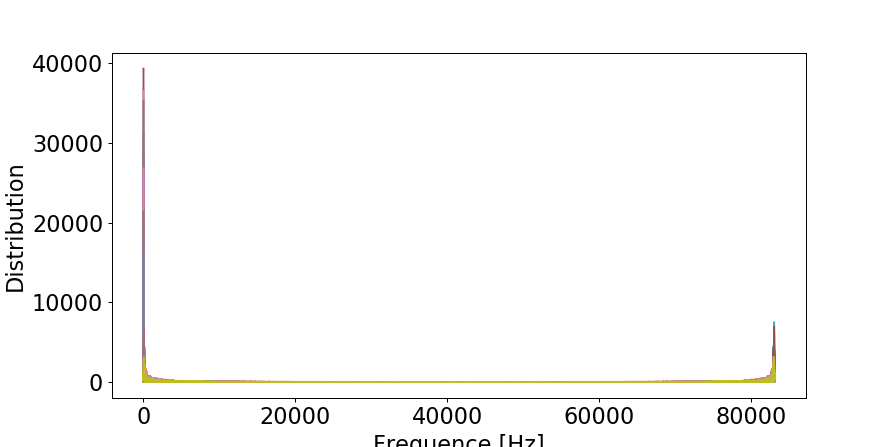

/gneven/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)
/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in exp


1000
s: inf
RMSE: 944.7100753316016



In [270]:

fft=scipy.fft(all_pd.iloc[:,4:],axis = 0)



fig = plt.figure(10,figsize = (10,5))
ax = fig.gca()


ax.plot(abs(fft))
ax.set(xlabel = 'Frequence [Hz]',ylabel = 'Distribution')

fft[60000:,:] = 0

            
X_s_test_db60_4 = scipy.ifft(fft)


Y_hat_test_noise_4 = model_rul.predict(x=np.concatenate((W_test_noise, X_s_test_db60_4),axis = 1))

scores_noise_4 = score_cal(Y_hat_test_noise_4, Y_test_noise)
print(sigma)
print(r's:',np.sum(scores_noise_4))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_noise_4 - Y_test_noise)**2)))

    
print('')




print_table_loss(['Model 1 :','Model 1 with noise :','Model 1 with gausian filter','Model 1 with moving average','Model 1 with FFT']
                 ,[np.sum(scores),np.sum(scores_noise),84367.99899580804,105585.73905557385,np.sum(scores_noise_4)
            ],[np.sqrt(np.mean((Y_hat_test - Y_test)**2)),np.sqrt(np.mean((Y_hat_test_noise - Y_test)**2))
               ,8.405575573099728,9.403357840681437,np.sqrt(np.mean((Y_hat_test_noise_4 - Y_test_noise)**2))],'Loss_table')

In [240]:
np.sum(scores_noise_4)

inf

**Plot predicted Vs. true RUL**

<IPython.core.display.Javascript object>


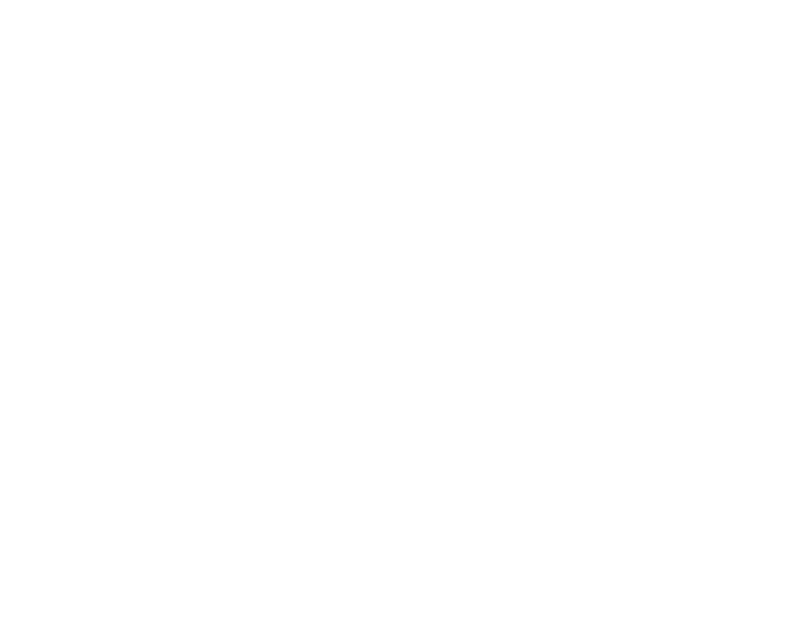

In [271]:
# True and predict vs time - Test Per engine
unit_sel = [11, 14, 15]
log_y_hat_test = [Y_hat_test]

# Plot rul
plot_predicted_true_rul(log_y_hat_test, unit_sel, U_test, C_test, Y_test,'plot4_RUL_1')



## Part 2: Prognostics with Generated Sensor Readings $X_{s*}$

### function definition

In [272]:
def gt_generative_model(model_sel, W, T, x0, n_w, n_t, n_out):
    """
    Uses the trained inference model to generate a sequence of values.
    
    Arguments:
    W -- np.array, operative conditions 
    T -- np.array, degradation condition
    x0 -- np.array, inital sensor readings
    n_w -- integer, dimensions of the operative conditions vector, w^{(t)}
    n_t -- integer, dimensions of the calibtation factors vector, \theta^{(t)}
    n_out -- integer, number of units in the ouput layer
    
    Returns:
    outputs -- np.array with predict gt_model response (i.e, $x_s$) 
    """
    
    # Set-up
    Ty = W.shape[0]
    outputs, inputs = np.empty((Ty,n_out)), np.empty((Ty,n_out+n_w+n_t)) # Create an empty list of "outputs" to later store your predicted values

    # Step 0: Define x0, initial input of the MLP
    outputs[0,:] = x0
    
    # Step 1: Load inference_model
    json_file = open(model_sel+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(model_sel+".h5")
    print("Loaded model from disk\n")
    toolbar_width = 43

        
    l = 0
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty-1):

        inputs[t+1:t+2,:] = np.concatenate((W[t+1:t+2,:],T[t+1:t+2,:],outputs[t:t+1,:]),axis = 1)
        # Step 2.A: Select "x" value according to "out" and expand "x" with "w" and "theta "i.e. "[w, out, theta]"
        
        outputs[t+1,:] = model.predict(inputs[t+1:t+2,:])
        # Step 2.B: Perform one step of MLP network
        
        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_out)
        
        if t%1000 == 0:
            sys.stdout.write(("["+l*"-"+ (toolbar_width-l)*" "+"]\r" ))
            sys.stdout.flush()
            l += 1
            
            
    return outputs, inputs

In [273]:

model_sel = '/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Python/ps4/model/model_h_0_run_0'
json_file = open(model_sel+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(model_sel+".h5")
print("Loaded model from disk\n")

model.summary()

Loaded model from disk

Model: "FF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               3600      
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               22650     
_________________________________________________________________
fc (Dense)                   (None, 100)               15100     
_________________________________________________________________
OUT (Dense)                  (None, 16) 

In [274]:
def predict_given_input(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out):
    """
    Predicts the next value of values using the generative model.
    
    Arguments:
    x_initializer -- numpy array of shape (1, n_x), input vector initializing the values generation
    W_gen -- numpy array of shape (Ty, n_w), input matrix with the w values for generation
    T_gen -- numpy array of shape (Ty, n_t), input matrix with the \theta values for generation
    
    Returns:
    results -- numpy-array of shape (Ty, 1, n_y), matrix representing the x_s values generated
    """
    
    # Step 1: Use the generative model to predict an output sequence given: W_gen, theta_gen, x_initializer.
    pred, x = gt_generative_model(model_sel, W_gen, T_gen, x_0, n_w, n_t, n_out)
    
    # Step 2: Convert "pred" into an np.array()
#     results = np.array(pred)
#     inputs = np.array(x)
    results = pred.reshape(pred.shape[0],1,pred.shape[1])
    inputs = x.reshape(x.shape[0],1,x.shape[1])
    return results[:,0, :], inputs[:,0, :]

**Define Future Conditions**

In [275]:
# Nominal future trajectories

# Set-up
n_out = X_s_path1.shape[-1]
n_w = W_path1.shape[-1]
n_t = T_path1.shape[-1]

# X0
x_gen = X_s_path1
x_0 = x_gen[1,:]
x_0.shape = (1, n_out)
print('X0 shape: ', x_0.shape)
print('Theta shape: ', T_path1.shape)

# w
W_gen = W_path1
print('W_gen shape: ', W_gen.shape)

C_gen  = C_path1
U_gen  = U_path1



X0 shape:  (1, 16)
Theta shape:  (42240, 3)
W_gen shape:  (42240, 4)


In [276]:
T_path2.shape


(42240, 3)

In [277]:
# Time tracking, Operation time (min):  0.4 per prediction
t = time.clock()

MODEL_PATH = '/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Python/ps4/model/'
model_sel = MODEL_PATH + '/' + 'model' + '_h_0_run_0'

X_s_hat_inf_1, X_inf_1 = predict_given_input(model_sel, W_gen, T_path1, x_0, n_w, n_t, n_out)
X_s_hat_inf_2, X_inf_2 = predict_given_input(model_sel, W_gen, T_path2, x_0, n_w, n_t, n_out)
X_s_hat_inf_3, X_inf_3 = predict_given_input(model_sel, W_gen, T_path3, x_0, n_w, n_t, n_out)

# Report time
print("Operation time (min): " , (time.clock()-t)/60)
print('')
print ("X_s_hat_inf shape: " + str(X_s_hat_inf_1.shape))
print ("X_inf shape: " + str(X_inf_1.shape))
print('')

Loaded model from disk



/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Loaded model from disk--------------------- ]

Loaded model from disk--------------------- ]

Operation time (min):  40.90008390000003--- ]

X_s_hat_inf shape: (42240, 16)
X_inf shape: (42240, 23)



/gneven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


In [278]:
# Unit 11
mask_11 = np.ravel((U_gen == 11))

# Unit 14
mask_14 = np.ravel((U_gen == 14))

# Unit 15
mask_15 = np.ravel((U_gen == 15))





(42240, 3)
['T24', 'T30', 'T40']


<IPython.core.display.Javascript object>


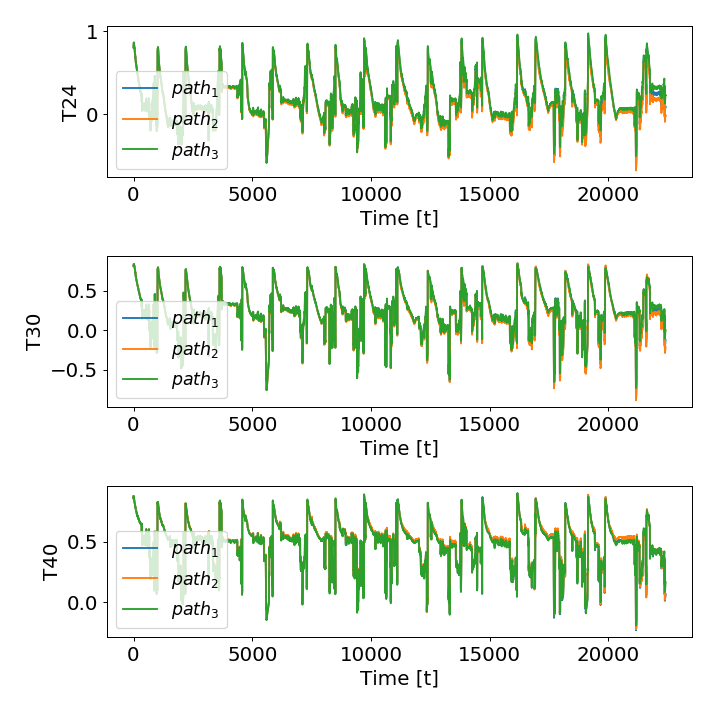

In [279]:
# Set-up
data, data[0] = {}, {}
data[0]['variables'] = varname[4:7]        # Variables names
print('')
print(T_path1.shape)
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = X_s_hat_inf_1[mask_11]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = X_s_hat_inf_2[mask_11]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = X_s_hat_inf_3[mask_11]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=8, option='idx')



['T24', 'T30', 'T40']


<IPython.core.display.Javascript object>


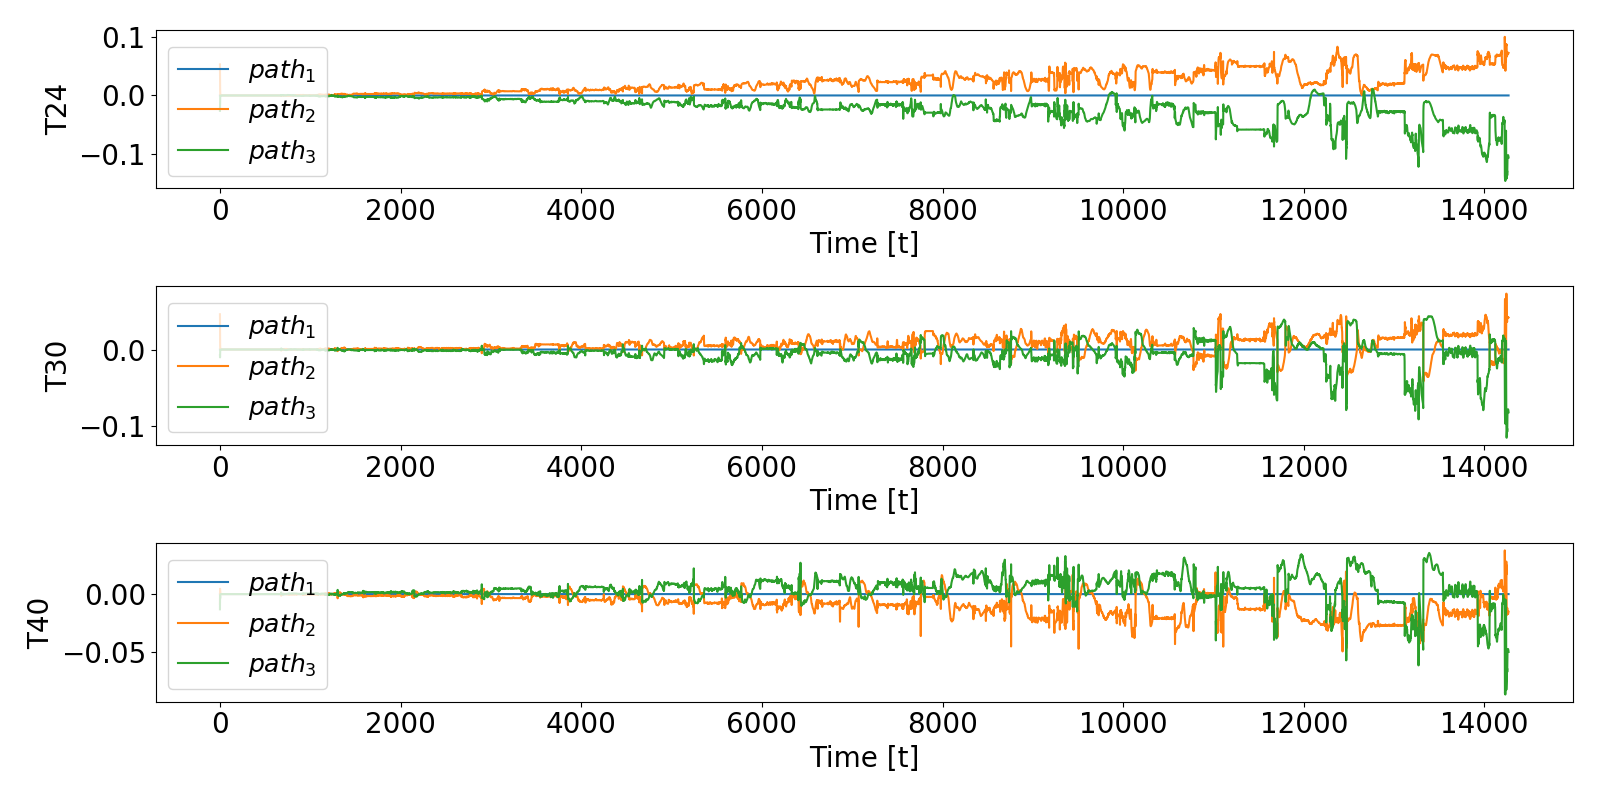

In [236]:
# Set-up
# dim1, dim2 = 1000, 2000
dim = mask_15
data, data[0] = {}, {}
data[0]['variables'] = varname[4:7]    # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = X_s_hat_inf_1[dim,:] - X_s_hat_inf_1[dim,:]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
# data[0]['path_2']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_2[dim1:dim2,:]
data[0]['path_2']['y'] = X_s_hat_inf_1[dim,:] - X_s_hat_inf_2[dim,:]

data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
# data[0]['path_3']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_3[dim1:dim2,:]
data[0]['path_3']['y'] = X_s_hat_inf_1[dim,:] - X_s_hat_inf_3[dim,:]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])



# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=(16,8), option='idx',labelsize = 20)#,name = 'plot5_delta_sensor_exemple'


In [36]:
varname

['alt',
 'Mach',
 'TRA',
 'T2',
 'T24',
 'T30',
 'T40',
 'T48',
 'T50',
 'P15',
 'P2',
 'P21',
 'P24',
 'Ps30',
 'P30',
 'P40',
 'P50',
 'Nf',
 'Nc',
 'Wf',
 'HPT_eff_mod',
 'LPT_eff_mod',
 'LPT_flow_mod']


['T24', 'T30', 'T40', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<IPython.core.display.Javascript object>


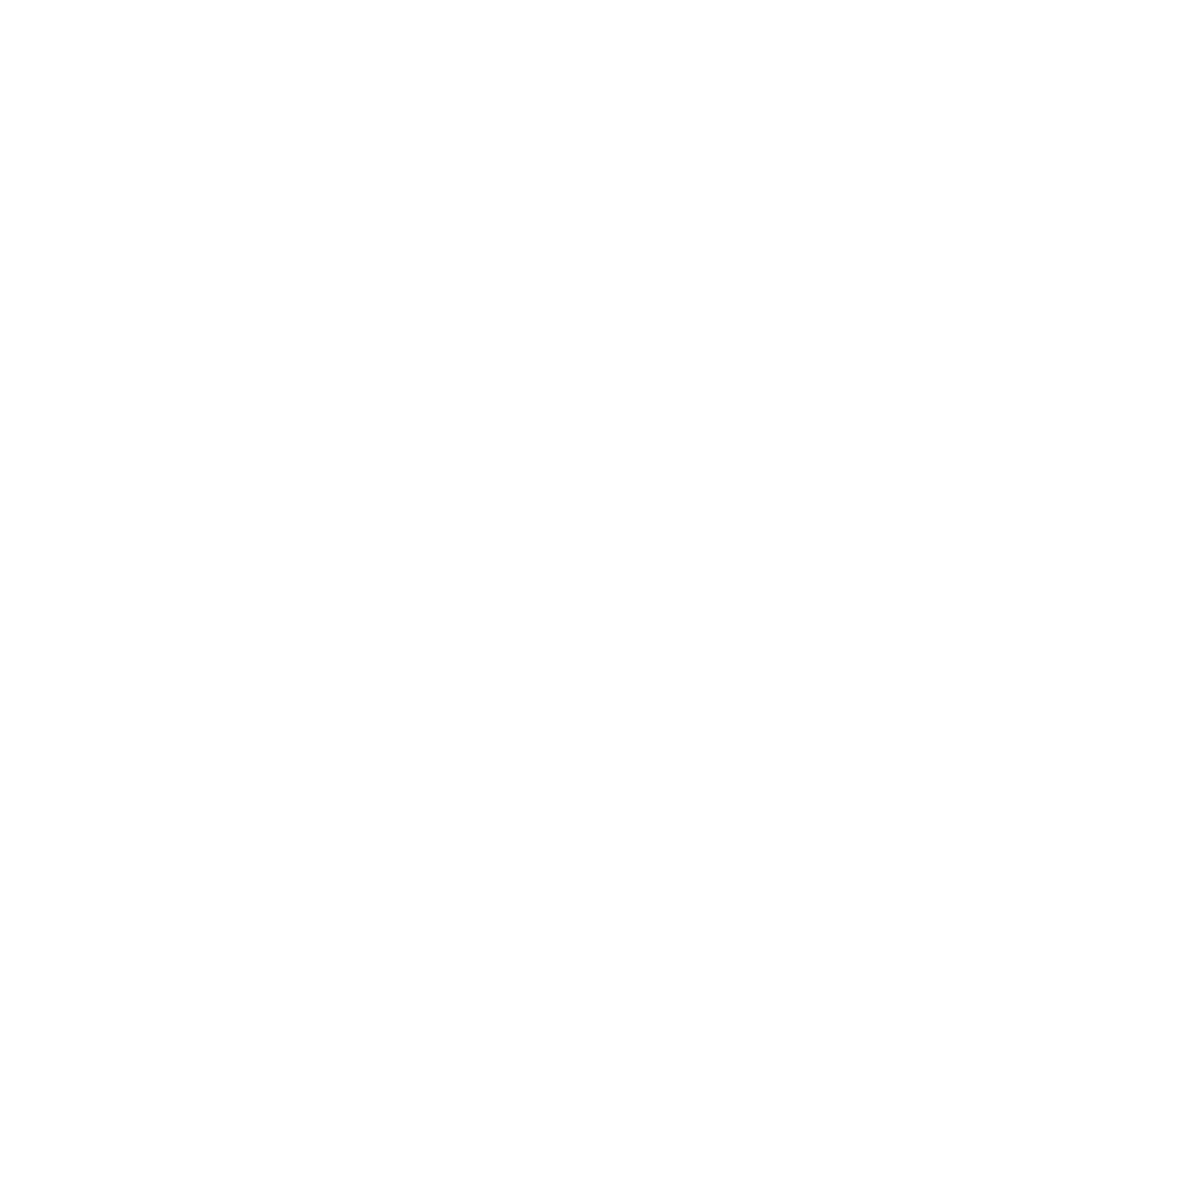

In [37]:
# Set-up
dim1, dim2 = 1000, 2000
data, data[0] = {}, {}
data[0]['variables'] = varname[4:20]       # Variables names
print('')
print(data[0]['variables'])

data[0]['label'] = data[0]['variables']
data[0]['legend'] = ['$path_1$', '$path_2$', '$path_3$']
data[0]['ds_name'] = ['path_1', 'path_2', 'path_3']
data[0]['option'] = 'Save'

# Data to plot
data[0]['path_1'] = {}
data[0]['path_1']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_1[dim1:dim2,:]
data[0]['path_1']['x'] = np.arange(data[0]['path_1']['y'].shape[0])

data[0]['path_2'] = {}
data[0]['path_2']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_2[dim1:dim2,:]
data[0]['path_2']['x'] = np.arange(data[0]['path_2']['y'].shape[0])

data[0]['path_3'] = {}
data[0]['path_3']['y'] = X_s_hat_inf_1[dim1:dim2,:] - X_s_hat_inf_3[dim1:dim2,:]
data[0]['path_3']['x'] = np.arange(data[0]['path_3']['y'].shape[0])

# Plot limits
x_max = None              # Max x
y_min = None              # Min y
y_max = None              # Max y

# Plot
plot_variables(data, figsize=12, option='idx')



### Prognostics with Generated Trajectories

In [53]:
# # Set-up
# MODEL_PATH = '/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Python/ps4/model/'
# model_sel = MODEL_PATH + '/' + 'model_FF_0'
# with open(model_sel + '.json', "r") as json_file:
#     loaded_model_json = json_file.read()
# rul_model = model_from_json(loaded_model_json)
# rul_model.load_weights(model_sel + '.h5')
# print('')
# print("Loaded RUL model from disk")
print(X_s_hat_inf_1.shape)
print(W_gen.shape)


(42240, 16)
(42240, 4)


**Predict RUL**

In [280]:
rul_path_1 = model_rul.predict(x=np.concatenate((W_gen, X_s_hat_inf_1), axis= 1))
rul_path_2 = model_rul.predict(x=np.concatenate((W_gen, X_s_hat_inf_2), axis= 1))
rul_path_3 = model_rul.predict(x=np.concatenate((W_gen, X_s_hat_inf_3), axis= 1))



log_rul_path_gen  = [rul_path_1, rul_path_2, rul_path_3] 

rul_path_1 == rul_path_2

array([[ True],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

<IPython.core.display.Javascript object>


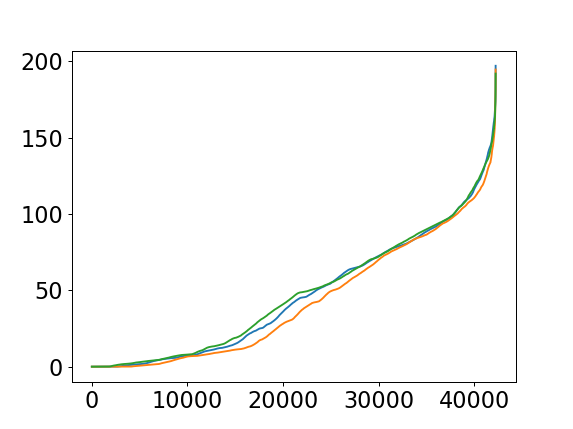

In [255]:
log_rul_path_gen[0].shape
log_y_hat_test[0].shape #42240

fig = plt.figure()
ax = fig.gca()
ax.plot(np.sort(rul_path_1,axis = 0))
ax.plot(np.sort(rul_path_2,axis = 0))
ax.plot(np.sort(rul_path_3,axis = 0))



<IPython.core.display.Javascript object>


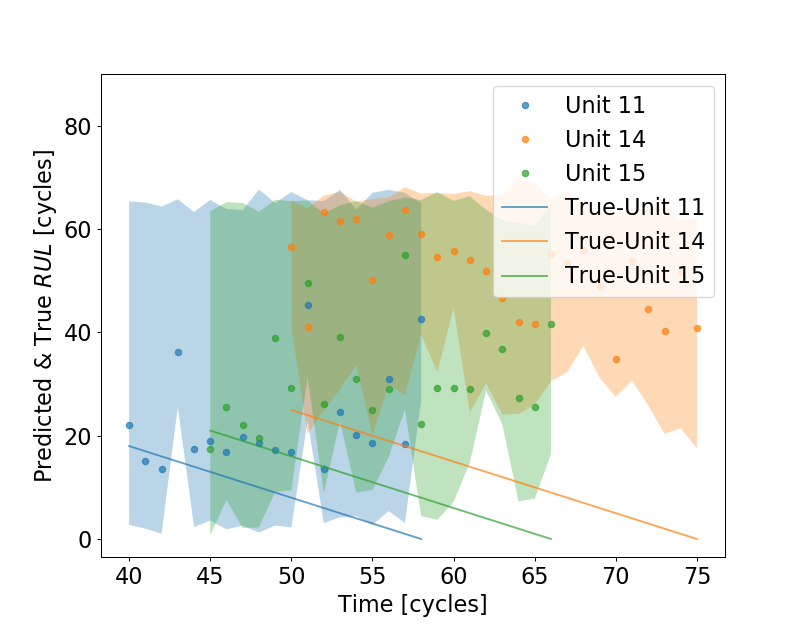

<IPython.core.display.Javascript object>


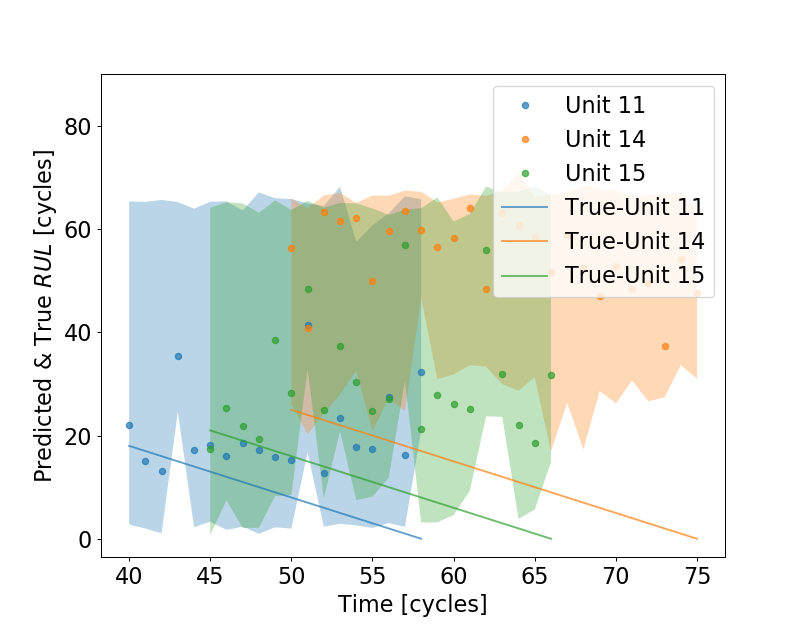

<IPython.core.display.Javascript object>


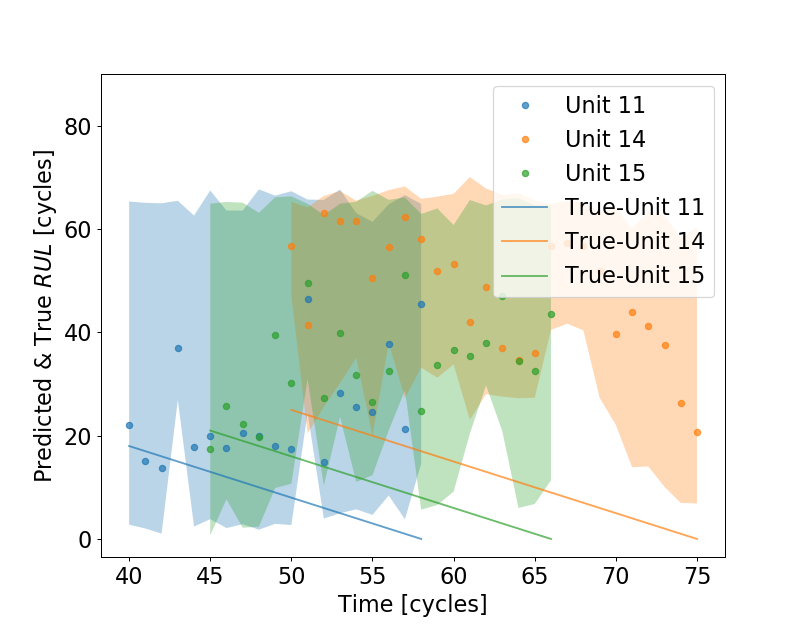

In [281]:
# True and predict vs time - Test Per engine
unit_sel = [11,14,15]

# Plot rul
plot_predicted_true_rul(log_rul_path_gen, unit_sel, U_path1, C_path1, Y_path1,'plot5_RUL_PATH')

print_table_loss(['Path_1','Path_2','Path_3']
                ,[np.sum(score_cal(rul_path_1,Y_path1)),np.sum(score_cal(rul_path_2,Y_path1)),np.sum(score_cal(rul_path_2,Y_path1))]
                ,[np.sqrt(np.mean((rul_path_1 - Y_path1)**2)),np.sqrt(np.mean((rul_path_2 - Y_path1)**2)),np.sqrt(np.mean((rul_path_3 - Y_path1)**2))]
                ,'Loss_Path')

<IPython.core.display.Javascript object>


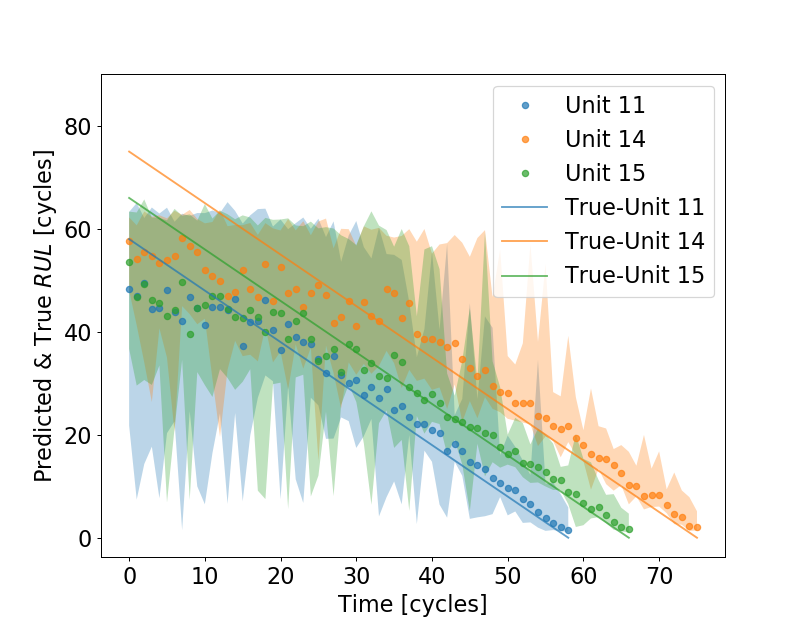

In [285]:
rul_full_test = model_rul.predict(x=np.concatenate((np.concatenate((W_test,W_path1),axis = 0),
                                                   np.concatenate((X_s_test,X_s_path1),axis = 0)), axis= 1))

plot_predicted_true_rul([rul_full_test], unit_sel, np.concatenate((U_test,U_path1)),
                        np.concatenate((C_test,C_path1)),
                        np.concatenate((Y_test,Y_path1)),'plot_all_test_RUL')


print_table_loss(['Path_1 + X_s'],[np.sum(score_cal(rul_full_test,np.concatenate((Y_test,Y_path1))))]
                ,[np.sqrt(np.mean((rul_full_test - np.concatenate((Y_test,Y_path1)))**2))],'LOSS_PATH')

## part 3: Fusing
### Denoised sensor

In [286]:
X_train, X_val, y_train, y_val  =  train_test_split(np.concatenate((W_train,X_s_train,X_s_train_deno),axis = 1
                                                                    ), Y_train, test_size=0.2, random_state=1)

model_1 = create_model(model_param['Hidden layers'],model_param['# of nodes'],-1,model_param['Dropout rate'],X_train.shape[1])

optimizer_m = adam.Adam(learning_rate= model_param['Learning rate'])#
model_1.compile(loss=RMSE,
                  optimizer=optimizer_m)
#                 ,metric=nasa_cost)


# hist_1 = model_1.fit(x=AllX,y = Y_train, epochs=10,
#               batch_size=int(2**(np.round(model_param['batch_size']))), verbose=1,validation_data=(X_val,y_val))

hist_1 = model_1.fit(x=X_train,y = y_train, epochs=10,
              batch_size=int(model_param['Batch size']), verbose=1,validation_data=(X_val,y_val)) 

Y_hat_test_1 = model_1.predict(x=np.concatenate((np.concatenate((W_test,W_path1),axis = 0),
                                                   np.concatenate((X_s_test,X_s_path1),axis = 0),
                                                 np.concatenate((X_s_test_deno,X_s_path1_deno),axis = 0)
                                                 ), axis= 1))

scores_1 = score_cal(Y_hat_test_1, np.concatenate((Y_test,Y_path1),axis = 0))

print('')
print(r's:', np.sum(scores_1))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_1 - np.concatenate((Y_test,Y_path1),axis = 0))**2)))




Train on 421077 samples, validate on 105270 samples
Epoch 1/10
421077/421077 [==============================] - 41s 98us/step - loss: 11.7403 - val_loss: 8.1853
Epoch 2/10
421077/421077 [==============================] - 41s 98us/step - loss: 8.8182 - val_loss: 8.1877
Epoch 3/10
421077/421077 [==============================] - 45s 107us/step - loss: 8.5377 - val_loss: 8.0679
Epoch 4/10
421077/421077 [==============================] - 47s 111us/step - loss: 8.3734 - val_loss: 8.2454
Epoch 5/10
421077/421077 [==============================] - 47s 112us/step - loss: 8.3129 - val_loss: 7.5826
Epoch 6/10
421077/421077 [==============================] - 48s 113us/step - loss: 8.2561 - val_loss: 8.1229
Epoch 7/10
421077/421077 [==============================] - 44s 104us/step - loss: 8.1493 - val_loss: 7.9462
Epoch 8/10
421077/421077 [==============================] - 46s 110us/step - loss: 8.0859 - val_loss: 7.3465
Epoch 9/10
421077/421077 [==============================] - 48s 114us/step - 

### Virtual sensor

In [337]:
X_train, X_val, y_train, y_val  =  train_test_split(np.concatenate((W_train,X_s_train,X_s_train_deno,X_v_train),axis = 1
                                                                    ), Y_train, test_size=0.2, random_state=1)

model_V = create_model(model_param['Hidden layers'],model_param['# of nodes'],-1,model_param['Dropout rate'],X_train.shape[1])

optimizer_m = adam.Adam(learning_rate= model_param['Learning rate'])
model_V.compile(loss=RMSE,
                  optimizer=optimizer_m)
#                 ,metric=nasa_cost)


# hist = model.fit(x=AllX,y = Y_train, epochs=10,
#               batch_size=int(2**(np.round(model_param['batch_size']))), verbose=1,validation_data=(X_val,y_val))

hist_v = model_V.fit(x=X_train,y = y_train, epochs=5,
                     batch_size=int(model_param['Batch size']), verbose=1,validation_data=(X_val,y_val))

Y_hat_test_v = model_V.predict(x=np.concatenate((np.concatenate((W_test,W_path1),axis = 0),
                                                   np.concatenate((X_s_test,X_s_path1),axis = 0),
                                                 np.concatenate((X_s_test_deno,X_s_path1_deno),axis = 0),
                                                 np.concatenate((X_v_test,X_v_path1),axis = 0)
                                                 ), axis= 1))



scores_v = score_cal(Y_hat_test_v, np.concatenate((Y_test,Y_path1),axis = 0))

print('')
print(r's:', np.sum(scores_v))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_v - np.concatenate((Y_test,Y_path1),axis = 0))**2)))



Train on 421077 samples, validate on 105270 samples
Epoch 1/5
421077/421077 [==============================] - 42s 100us/step - loss: 10.9435 - val_loss: 7.7279
Epoch 2/5
421077/421077 [==============================] - 44s 103us/step - loss: 8.4751 - val_loss: 7.7566
Epoch 3/5
421077/421077 [==============================] - 45s 108us/step - loss: 8.2984 - val_loss: 7.3573
Epoch 4/5
421077/421077 [==============================] - 45s 107us/step - loss: 8.1427 - val_loss: 7.4471
Epoch 5/5
421077/421077 [==============================] - 48s 113us/step - loss: 8.0474 - val_loss: 8.4630

s: 158709.07487348918
RMSE: 8.289153702725397


###  All

In [288]:
X_train, X_val, y_train, y_val  =  train_test_split(np.concatenate((W_train,X_s_train,X_s_train_deno,X_v_train,T_train),axis = 1
                                                                    ), Y_train, test_size=0.2, random_state=1)
model_all = create_model(model_param['Hidden layers'],model_param['# of nodes'],-1,model_param['Dropout rate'],X_train.shape[1])

model_all.compile(loss=RMSE,
                  optimizer=optimizer_m)
#                 ,metric=nasa_cost)



hist_all = model_all.fit(x=X_train,y = y_train, epochs=10,
              batch_size=int(model_param['Batch size']), verbose=1,validation_data=(X_val,y_val))

Y_hat_test_all = model_all.predict(x=np.concatenate((np.concatenate((W_test,W_path1),axis = 0),
                                                   np.concatenate((X_s_test,X_s_path1),axis = 0),
                                                 np.concatenate((X_s_test_deno,X_s_path1_deno),axis = 0),
                                                 np.concatenate((X_v_test,X_v_path1),axis = 0),
                                                np.concatenate((T_test,T_path1),axis = 0)
                                                 ), axis= 1))
scores_all= score_cal(Y_hat_test_all, np.concatenate((Y_test,Y_path1),axis = 0))

print('')
print(r's:', np.sum(scores_all))
print('RMSE:', np.sqrt(np.mean((Y_hat_test_all - np.concatenate((Y_test,Y_path1),axis = 0))**2)))


Train on 421077 samples, validate on 105270 samples
Epoch 1/10
421077/421077 [==============================] - 43s 101us/step - loss: 6.5808 - val_loss: 5.0922
Epoch 2/10
421077/421077 [==============================] - 42s 99us/step - loss: 5.8219 - val_loss: 4.9959
Epoch 3/10
421077/421077 [==============================] - 42s 100us/step - loss: 5.6717 - val_loss: 5.4091
Epoch 4/10
421077/421077 [==============================] - 42s 100us/step - loss: 5.5868 - val_loss: 5.0056
Epoch 5/10
421077/421077 [==============================] - 43s 103us/step - loss: 5.5269 - val_loss: 4.9406
Epoch 6/10
421077/421077 [==============================] - 42s 100us/step - loss: 5.4357 - val_loss: 4.9889
Epoch 7/10
421077/421077 [==============================] - 42s 99us/step - loss: 5.4353 - val_loss: 4.9213
Epoch 8/10
421077/421077 [==============================] - 41s 99us/step - loss: 5.3564 - val_loss: 4.7915
Epoch 9/10
421077/421077 [==============================] - 42s 100us/step - lo

In [289]:
print_table_loss(['Model 1','Denoised','Virtual','Calibration factor']
                ,[np.sum(scores_1),np.sum(scores_v),np.sum(scores_all)]
                ,[np.sqrt(np.mean((Y_hat_test_1 - np.concatenate((Y_test,Y_path1),axis = 0))**2))
                , np.sqrt(np.mean((Y_hat_test_v - np.concatenate((Y_test,Y_path1),axis = 0))**2)),
                 np.sqrt(np.mean((Y_hat_test_all - np.concatenate((Y_test,Y_path1),axis = 0))**2))]
                 ,'all_loss'
                )

<IPython.core.display.Javascript object>


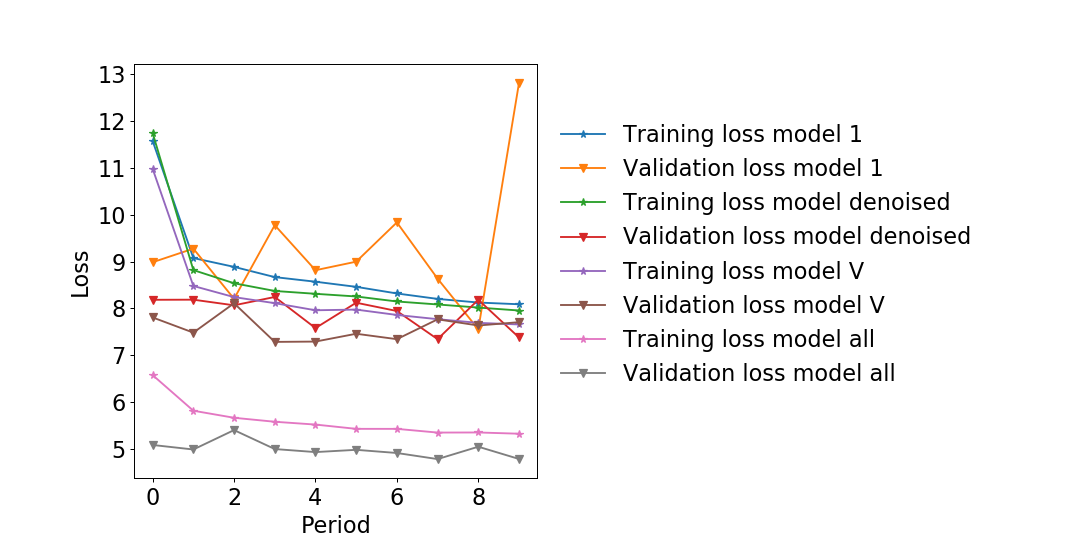

In [336]:
%matplotlib notebook

fig = plt.figure(6,figsize = (12,6))
ax = fig.gca()
ax.plot(hist.history['loss'],marker = '*',label = 'Training loss model 1')
ax.plot(hist.history['val_loss'],marker = 'v',label = 'Validation loss model 1')
ax.plot(hist_1.history['loss'],marker = '*',label = 'Training loss model denoised')
ax.plot(hist_1.history['val_loss'],marker = 'v',label = 'Validation loss model denoised')
ax.plot(hist_v.history['loss'],marker = '*',label = 'Training loss model V')
ax.plot(hist_v.history['val_loss'],marker = 'v',label = 'Validation loss model V')
ax.plot(hist_all.history['loss'],marker = '*',label = 'Training loss model all')
ax.plot(hist_all.history['val_loss'],marker = 'v',label = 'Validation loss model all')

ax.set(xlabel = 'Period',ylabel='Loss')
plt.legend(loc='lower right', bbox_to_anchor= (2.1,.2),
            borderaxespad=0, frameon=False)
fig.subplots_adjust(right=0.5)

plt.savefig('/gneven/ETH/Sem2/Predictive_maintenance/Assignment/Assignment4/Overleaf/figures/Loss_all.pdf',format = 'pdf')


<IPython.core.display.Javascript object>


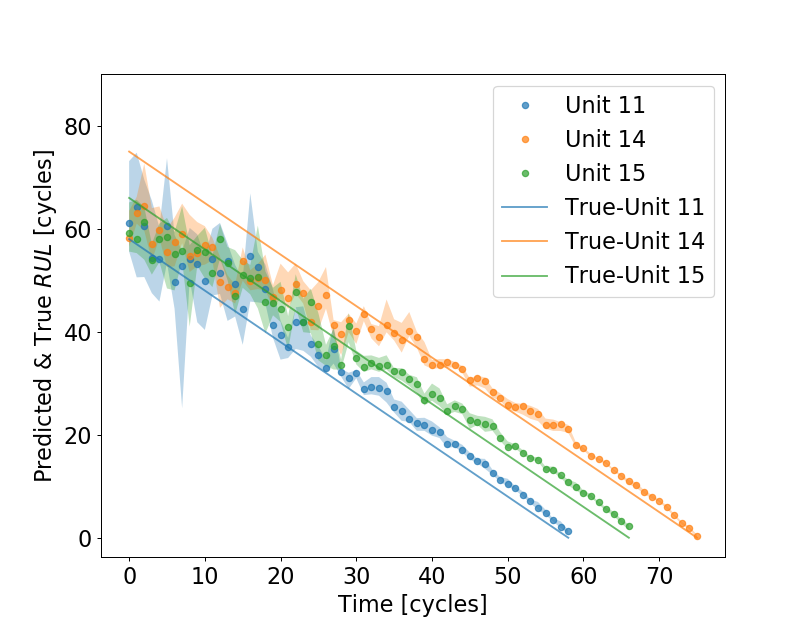

In [291]:
plot_predicted_true_rul([Y_hat_test_all], unit_sel, np.concatenate((U_test,U_path1)),
                        np.concatenate((C_test,C_path1)),
                        np.concatenate((Y_test,Y_path1)),'plot7_RUL_Final')
